# Assignment 1 - Mini Batch SGD for Linear Image Classification


In this exercise you will:
    
- implement a **loss function** for a linear classifier
- **optimize** the loss function with **SGD**
- use a validation set to **tune the hyperparameter (learning rate, regularization strength, regularization type, mini batch size.)**
- **visualize** the final learned weights

# Download your dataset


Before starting you should download and set your dataset.

1) Download from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

2) Extract the .tar.gz file into your `assignment1/datasets` folder

3) Check that the 8 files of the dataset are in the folder `assignment1/datasets/cifar-10-batches-py/`

4) You may find useful information about the dataset in the readme.html of that folder

In [257]:
# Run some setup code for this notebook.
import random
import numpy as np
from classUtils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This makes matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [258]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


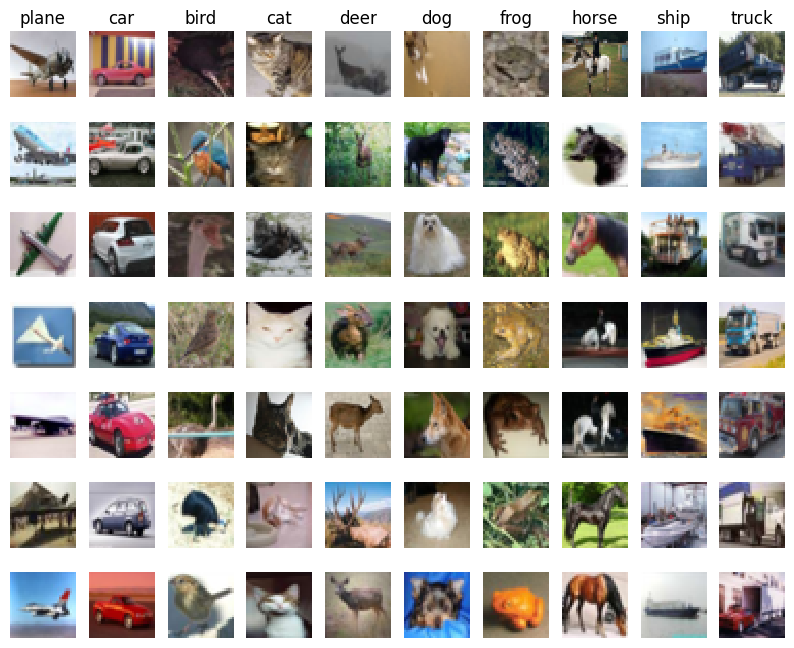

In [259]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [260]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print(f'Train data shape: {X_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Train data shape: (49000, 32, 32, 3)
Train labels shape: (49000,)
Validation data shape: (1000, 32, 32, 3)
Validation labels shape: (1000,)
Test data shape: (1000, 32, 32, 3)
Test labels shape: (1000,)


In [261]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'dev data shape: {X_dev.shape}')

Training data shape: (49000, 3072)
Validation data shape: (1000, 3072)
Test data shape: (1000, 3072)
dev data shape: (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


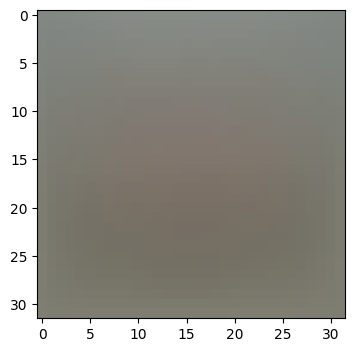

In [262]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [263]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [264]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## 1. Stochastic Gradient Descent

Your code for this section will all be written inside **compute_gradient_and_loss.py**.

-As a ﬁrst step, you will need to correctly fill-in the method 'compute_gradient_and_loss' that takes as input a set of training samples and computes the loss and the gradient of the loss (for the given training samples). 

-You will call this function inside the **train_linear_classifer method** of the **LinearClassifier Class** in the  **linear_classifier.py** file in order to compute the gradient of each mini-batch, and for collecting the sequence of all mini-batch losses during training as well as the sequence of all validation losses during training.

In [265]:
# Check that the implementation of the compute_gradient_and_loss function is ok by calling it directly using random W as input.
from classUtils.classifiers.compute_gradient_loss import *
import time

# generate a random classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = compute_gradient_and_loss(W, X_dev, y_dev, 0.00001, 2, 0)
print(f'loss: {loss}')

loss: 9.229404137099277


## 2. Implement your linear classifier

To implement your linear classifier, you will need to fill-in the following
two functions: 

'train_linear_classifier': this is the method of class LinearClassifier responsible for training the
classiﬁer using mini-batch SGD. It should return the parameters of the
trained classiﬁer and the sequence of all mini-batch losses during training
as well as the sequence of all validation losses during training.

'predict_image_class': this is the method of class LinearClassifier  takes as input an image and uses a
trained classiﬁer to predict its class (recall that the predicted class should
be the one that is assigned the maximum score by the trained classifer).

iteration No 0 / 1470: loss 1558.7396178350868
iteration No 0 / 1470: validation loss 1527.0794688824435
iteration No 100 / 1470: loss 209.7397032790253
iteration No 100 / 1470: validation loss 206.44127063521864
iteration No 200 / 1470: loss 32.85966902208324
iteration No 200 / 1470: validation loss 32.368941504267255
iteration No 300 / 1470: loss 9.636362621259817
iteration No 300 / 1470: validation loss 9.310910121446595
iteration No 400 / 1470: loss 5.973357146686357
iteration No 400 / 1470: validation loss 6.281710745265299
iteration No 500 / 1470: loss 5.771881277068398
iteration No 500 / 1470: validation loss 5.8798821627951545
iteration No 600 / 1470: loss 5.792275493808131
iteration No 600 / 1470: validation loss 5.82952679293992
iteration No 700 / 1470: loss 5.527793700120898
iteration No 700 / 1470: validation loss 5.808342412131705
iteration No 800 / 1470: loss 5.6587902131770935
iteration No 800 / 1470: validation loss 5.837399393978679
iteration No 900 / 1470: loss 5.9335

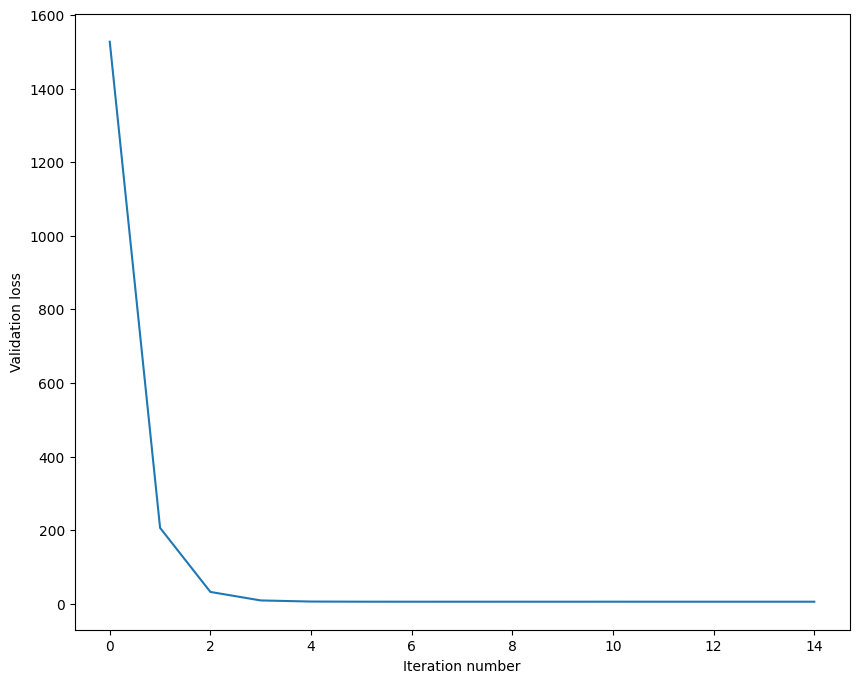

In [266]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train_linear_classifier() and then run it with the code below.
# Plot the loss of the training process as a function of iteration number.

from classUtils.classifiers.linear_classifier import LinearClassifier
cifarLC = LinearClassifier()
tic = time.time()

loss_hist, val_loss_hist = cifarLC.train_linear_classifier(X_train, y_train, X_val, y_val, learning_rate=1e-7, reg=5e4, \
                                        reg_type = 2, num_epochs=6, batch_size = 200, num_valid_loss_evals = 100, verbose=True)
toc = time.time()
print(f'Time elapsed: {toc - tic} secs')

# A useful debugging strategy is to plot the loss as a function of iteration number !

plt.plot(val_loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Validation loss')
plt.show()

In [267]:
# Implement the LinearClassifier.predict_image_class function and evaluate the performance on both the
# training and validation set
y_train_pred = cifarLC.predict_image_class(X_train)
print(f'training accuracy: {np.mean(y_train == y_train_pred)}')

y_val_pred = cifarLC.predict_image_class(X_val)
print(f'validation accuracy: {np.mean(y_val == y_val_pred)}')

training accuracy: 0.35416326530612247
validation accuracy: 0.364


### 3. Choose the best hyperparameters using the validation set

You will use the validation set in order to choose proper values for some of the hyperparameters of the problem 
(these include the regularization strength, the mini-batch size, learning rate and the type of regularization l1 or l2). 

To that end, you will train linear classiﬁers for a diﬀerent number of combinations of these hyperparameters
and you will choose as your ﬁnal classiﬁer the one that achieves the highest accuracy in the validation set.

In [268]:
# Use the validation set to tune hyperparameters (regularization type and strength, learning rate and batch size). 
# You can run your experiments using the following 8 combinations (columnwise) 
# You are encouraged to use your own combinations on different ranges of the hyperparameters to achieve the highest accuracy.
# If you are careful you should be able to get a classification accuracy of about 0.4 on the validation set.
learning_rates          = [1e-8, 1e-7, 3e-7, 3e-7, 5e-7, 8e-7, 1e-6, 1e-5]
regularization_strengths= [1e4,  3e4,  5e4,   1e4, 8e4,  1e5,  5e4,  5e5 ]
regularization_type     = [1,      2,    1,     2,   1,    2,    1,    2 ] # 1,2 for l1, l2 respectively
batch_size              = [50,   100,  200,   400, 100,  200,  200,  400 ]
num_epochs = 6

# results is a container for saving the results of your cross-validation
# HINT : you can use a dictionary for mapping tuples of the form
# (learning_rate, regularization_strength, regularization_type, batch_size) 
# to tuples of the form (training_accuracy, validation_accuracy). 
# The accuracy is simply the fraction of data points that are correctly classified.
results = []
best_train_val = -1   # The highest training accuracy that we have seen so far.
best_valid_val = -1   # The highest validation accuracy that we have seen so far.
best_classifier = None # The LinearClassifier object that achieved the highest validation rate.
best_lr = best_reg = best_reg_type = best_batch_size = 0
#################################################################################
# TODO:                                                                         #
# Write code that chooses the best hyperparameters by tuning on the validation  #
# set. For some combinations of hyperparameters, train a linear clasifier on    #
# the training set, compute its accuracy on the training and validation sets,   #
# store these numbers in the results dictionary. In addition, store the best    #
# validation accuracy in best_val and the LinearClassifier object that achieves #
# this accuracy in best_classifier.                                             #
# !!! Also, print out or plot the resulting accuracy for the selected           #
# combinations of your hyperparameters.                                         #
#################################################################################

for i in range(len(learning_rates)):
    lr = learning_rates[i]
    reg = regularization_strengths[i]
    reg_type = regularization_type[i]
    batch = batch_size[i]
    lc = LinearClassifier()
    loss_hist, val_loss_hist = lc.train_linear_classifier(X_train, y_train, X_val, y_val, learning_rate=lr, reg=reg, \
                                        reg_type = reg_type, num_epochs=num_epochs, batch_size = batch, num_valid_loss_evals = 100, verbose=True)
    y_train_pred = lc.predict_image_class(X_train)
    y_val_pred = lc.predict_image_class(X_val)
    train_acc = np.mean(y_train == y_train_pred)
    valid_acc = np.mean(y_val == y_val_pred)
    results.append((train_acc, valid_acc))
    if valid_acc > best_valid_val:
        best_valid_val = valid_acc
        best_train_val = train_acc
        best_classifier = lc
        best_lr = lr
        best_reg = reg
        best_reg_type = reg_type
        best_batch_size = batch
        best_lost_hist = loss_hist
        best_val_loss_hist = val_loss_hist
    print(f'lr: {lr} reg: {reg} reg_type: {reg_type} batch: {batch} train_acc: {train_acc} valid_acc: {valid_acc}')
pass
#################################################################################
#                              END OF YOUR CODE                                 #
#################################################################################
    
print(f'best training and validation accuracy achieved during cross-validation: {best_train_val} and {best_valid_val}')
print(f'using parameters: lr {best_lr} reg {best_reg} reg_type {best_reg_type} and batch_size {best_batch_size}')

iteration No 0 / 5880: loss 243914.1507923095
iteration No 0 / 5880: validation loss 215652.10820923038
iteration No 100 / 5880: loss 15285.870511904746
iteration No 100 / 5880: validation loss 15460.4366113752
iteration No 200 / 5880: loss 15295.15534972949
iteration No 200 / 5880: validation loss 15453.010155408463
iteration No 300 / 5880: loss 15347.115421140217
iteration No 300 / 5880: validation loss 15399.400723186753
iteration No 400 / 5880: loss 15389.420824173812
iteration No 400 / 5880: validation loss 15358.073840569143
iteration No 500 / 5880: loss 15353.882728830686
iteration No 500 / 5880: validation loss 15395.608718074685
iteration No 600 / 5880: loss 15349.335908277784
iteration No 600 / 5880: validation loss 15398.269600207592
iteration No 700 / 5880: loss 15363.962432125245
iteration No 700 / 5880: validation loss 15383.234477093582
iteration No 800 / 5880: loss 15380.804810213895
iteration No 800 / 5880: validation loss 15366.576712684217
iteration No 900 / 5880: lo

### 4. Test your best classifier and visualize the learnt weights

For the ﬁnal classiﬁer, you should 

1) draw (in the same plot) the sequence of mini-batch losses and validation losses  collected during training. 

2) Evaluate the classiﬁer on the test set and report the achieved test accuracy

3) visualize (as images) the weights W (one image per row of W).

In [269]:
lc = LinearClassifier()
loss_hist, val_loss_hist = lc.train_linear_classifier(X_train, y_train, X_val, y_val, learning_rate=8e-07, reg=500.0, \
                                        reg_type = 2, num_epochs=6, batch_size = 512, num_valid_loss_evals = 100, verbose=True)
y_train_pred = lc.predict_image_class(X_train)
print(f'training accuracy: {np.mean(y_train == y_train_pred)}')

iteration No 0 / 574: loss 33.84783103508381
iteration No 0 / 574: validation loss 31.47283290854959
iteration No 100 / 574: loss 20.486799027286427
iteration No 100 / 574: validation loss 20.008988243284737
iteration No 200 / 574: loss 17.012541176204703
iteration No 200 / 574: validation loss 17.12426807663777
iteration No 300 / 574: loss 14.788686242605035
iteration No 300 / 574: validation loss 14.971951798567035
iteration No 400 / 574: loss 12.578950642102502
iteration No 400 / 574: validation loss 13.236681331640588
iteration No 500 / 574: loss 11.708218556032458
iteration No 500 / 574: validation loss 11.795564178509697
training accuracy: 0.36048979591836733


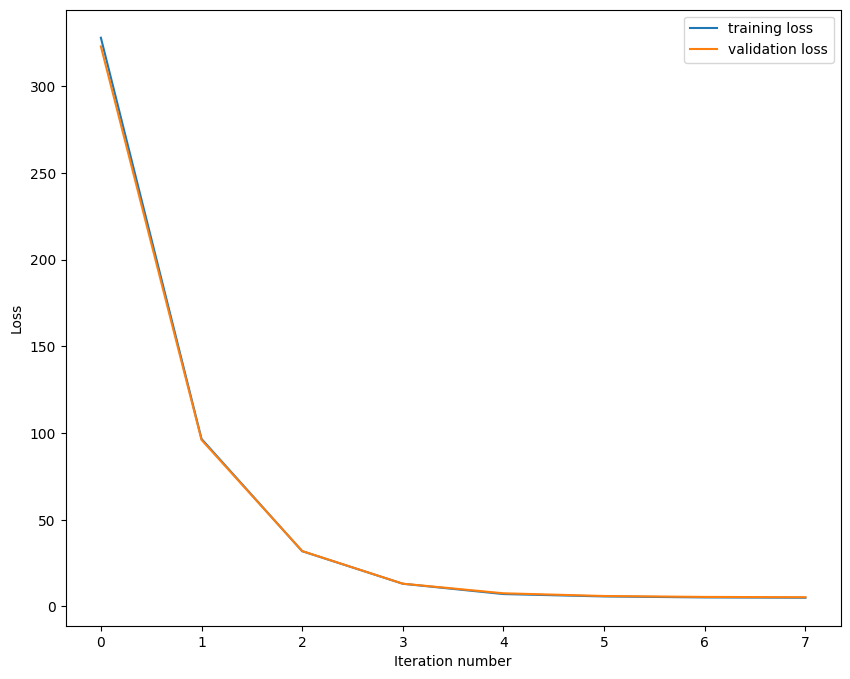

In [270]:
################################################################################
# TODO:  Get the mini-batch training losses and validation losses collected    #
# during training of your best classifier and plot in the same plot            #
################################################################################
plt.plot(best_lost_hist, label='training loss')
plt.plot(best_val_loss_hist, label='validation loss')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.legend()
plt.show()

pass

In [271]:
###################################################################################
# TODO:  Evaluate the best_classifier on the test set and plot/print the accuracy #
###################################################################################
test_accuracy = 0
y_test_pred = best_classifier.predict_image_class(X_test)
test_accuracy = np.mean(y_test == y_test_pred)

print(f'linear classifier on raw pixels final test set accuracy: {test_accuracy}')

linear classifier on raw pixels final test set accuracy: 0.373


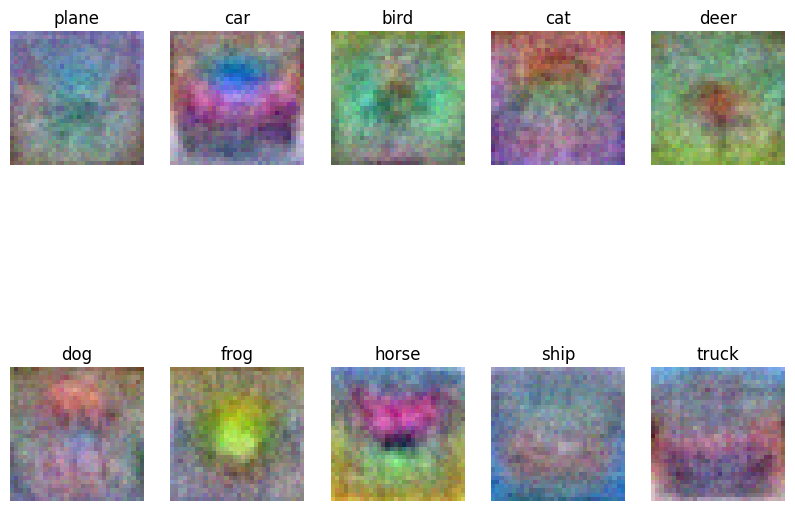

In [272]:
# Visualize the learned weights for each class.
#IF you have calculated valid W weights just the following routine will visualize the learned weights
#Just run the following lines of code

w = best_classifier.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])